In [1]:
import timeit

import warnings
warnings.filterwarnings("ignore")

# imports best practice pandas
import os

import numpy as np
import pandas as pd
import missingno as msno
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
%matplotlib inline
import math
import pickle
import gzip

import inspect
import plotly.graph_objects as go
pd.set_option('display.max_columns', None)

#--------------------------------------------------------
# imports best practice sklearn
import sklearn
from sklearn.feature_selection import VarianceThreshold
from sklearn import set_config

from sklearn.tree import DecisionTreeClassifier

# preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder, RobustScaler, MinMaxScaler
from scipy import stats

# transformers
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import FunctionTransformer


from sklearn.cluster import KMeans

# evaluacion
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics

# pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
set_config(transform_output = "pandas")

#models
from sklearn.cluster import KMeans

### Funciones Útiles

In [2]:
# Función para lista de variables

def listarNulos(dataset):
    df_stat = dataset.isnull().sum()[(dataset.isnull().sum()>0)].sort_values(ascending=False).to_frame()
    df_stat.rename(columns={0: 'Nulos'}, inplace = True)
    percent = (df_stat["Nulos"]/dataset.shape[0]).mul(100)
    df_stat["porcentaje"] = percent.round(2)
    return df_stat


def obtener_lista_variables(dataset,target,index):

  lista_numericas = []
  lista_boolean = []
  lista_categoricas = []
  lista_fecha = []

  for i in dataset:
    print(i)
    if ((dataset[i].dtype.kind == 'i') or (dataset[i].dtype.kind == 'f')) and i not in target and i not in index\
    and len(dataset[i].unique()) != 2:
      lista_numericas.append(i)

    elif ((dataset[i].dtype.kind == 'i') or (dataset[i].dtype.kind == 'f') or (dataset[i].dtype.kind == 'b')) and i not in target and i not in index\
    and len(dataset[i].unique()) == 2:
      lista_boolean.append(i)

    elif (dataset[i].dtype.kind == 'O') and i not in target and i not in index:
      lista_categoricas.append(i)
      
    elif (dataset[i].dtype.kind == 'M') and i not in target and i not in index:
      lista_fecha.append(i)

  return lista_numericas, lista_boolean, lista_categoricas, lista_fecha



def generar_grafico_radar(categories, values,title_gra, color_gra):

    # generar figura
    fig = go.Figure()

    # Adicionar trace para la série de dadtos
    fig.add_trace(go.Scatterpolar(
        r=values,
        theta=categories,
        fill='toself',
        #line=dict(color='blue')
        line=dict(color=color_gra)
    ))

    # Actualizar layout
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                #range=[0, max(values)]  # Escala adaptable
                range=[0, 1]  
            )),
            
        showlegend=False,
        title=title_gra,
        font=dict(
            family='Arial, sans-serif',
            size=18,
            color='black'
        ),
        margin=dict(
            l=30,
            r=30,
            t=50,
            b=10
        ),
        polar_angularaxis_rotation=0,  # Rotacionando os rótulos do eixo angular em 90 graus
        width=900,  # anchura
        height=450  # altura
    )

    return fig


### Carga de Datasets

In [3]:

FILEPATH_DATA_INPUT_PROCESSED = "../../data/processed/"
FILE = "df_marketing_10k_MERGED_ALL_LAST_PARTITION.pkl.gz"

# Usa gzip.open para abrir el archivo comprimido
with gzip.open(FILEPATH_DATA_INPUT_PROCESSED+FILE, 'rb') as gz_csv_products:
    df_emails = pd.read_pickle(gz_csv_products)

print("DataFrame cargado exitosamente")

DataFrame cargado exitosamente


In [4]:
df_emails

,pk_cid,increased_nr_accounts_10_m+1,increased_nr_accounts_10_m+1_proba,ROI_nr_accounts_10_m+1,increased_nr_invest_savings_40_m+1,increased_nr_invest_savings_40_m+1_proba,ROI_nr_invest_savings_40_m+1,increased_nr_financing_60_m+1,increased_nr_financing_60_m+1_proba,ROI_nr_financing_60_m+1,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,margen_esperado_max,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,age_cat,regions_ca_id,customer_acquisition_channel,nr_product,nr_accounts,nr_saving_and_investment,nr_financing,nr_product_max,nr_product_gap_to_max,nr_investment,product_mix_diversity,salary_CA,customer_tenure,digital_interaction_index,financial_health_score,entry_channel_salary,entry_channel_loyalty,periods_active,season,entry_date_month,entry_date_year,working_day,loan_utilization_index,ES_Flag,client_fidelity,total_products,nr_debt,entry_channel_product,channel_activity_level,nr_product_trend,nr_financing_60,nr_invest_savings_40,nr_account_10,nr_financing_60_trend,nr_invest_savings_40_trend,nr_account_10_trend,saving_behavior,nr_risk_low,nr_risk_medium,nr_risk_high,percent_risk_low,percent_risk_medium,percent_risk_high,risk_index_absolute,life_stage_indicator,customer_lifetime_value_partition,customer_lifetime_value_cumsum,months_from_last_purchase,date_last_purchase,active_customer_rate,months_from_last_purchase_digital,date_last_purchase_digital,total_products_ratio,customer_acquisition_channel_min,regions_cluster,nr_transactions,profit_60,profit_40,profit_10,total_profit_customer,cluster
0,1454294,0,0.002202,0.000000,0,0.004779,0.000000,1,0.999298,59.957900,0.000000,0.000000,59.957900,59.957900,2019-05-28,2018-09-18,KHQ,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,21.0,H,21,0,38513.97,"(20.0, 30.0]",AN,KH,1,1,0,0,2,1,0,0.083333,11977.0,252,1.00,0.000666,97521.064767,249.517699,4,Low_Season,9,2018,1,0,1,losing_fidelity,1,1,em_acount,0.302375,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Adulto Joven,-60.0,10.0,3,2019-02-28,0.444444,3,2019-02-28,0.066667,Prefix,AN,2.0,60.0,0.0,0.0,60.0,6.0
1,1394148,0,0.184762,0.000000,0,0.021956,0.000000,1,0.996987,59.819230,0.000000,0.000000,59.819230,59.819230,2019-05-28,2018-04-27,KHK,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,45.0,V,93,0,42671.28,"(90.0, inf]",CM,KH,1,1,0,0,2,1,0,0.083333,15129.0,396,1.00,0.000738,110141.452954,471.405757,14,Low_Season,4,2018,1,0,1,losing_fidelity,1,1,em_acount,0.639291,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Anciano+,-60.0,10.0,1,2019-04-28,1.000000,1,2019-04-28,0.066667,Prefix,Otros,12.0,360.0,0.0,0.0,360.0,3.0
2,1060165,0,0.420864,0.000000,0,0.003649,0.000000,1,0.996780,59.806809,0.000000,0.000000,59.806809,59.806809,2019-05-28,2015-09-14,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,ES,3.0,V,27,0,70929.06,"(20.0, 30.0]",VC,KH,3,0,1,2,4,1,1,0.177778,13643.0,1352,0.00,0.167894,108529.905617,964.341855,17,Low_Season,9,2015,1,0,1,losing_fidelity,3,1,payroll,0.253152,-1.0,0,1,2,-1.0,0.0,0.0,1,3,0,0,0.333333,0.0,0.0,1,Adulto Joven,-60.0,60.0,16,2018-01-28,1.000000,16,2018-01-28,0.200000,Prefix,VC,1.0,0.0,0.0,0.0,0.0,1.0
3,1435125,0,0.358099,0.000000,0,0.286869,0.000000,1,0.995976,59.758555,0.000000,0.000000,59.758555,59.758555,2019-05-28,2018-08-12,KHM,1,02 - PARTICULARES,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,ES,8.0,H,72,0,183746.82,"(70.0, 80.0]",CT,KH,2,1,0,1,3,1,0,0.138889,17459.0,289,0.50,0.003180,100706.027824,192.100628,9,Low_Season,8,2018,0,0,1,losing_fidelity,2,2,em_acount,0.635886,-1.0,1,0,1,-1.0,0.0,0.0,0,1,0,1,0.111111,0.0,0.2,3,Anciano,-60.0,70.0,4,2019-01-28,0.900000,4,2019-01-28,0.133333,Prefix,CT,4.0,120.0,0.0,10.0,130.0,3.0
4,1390071,1,0.644932,6.449317,1,0.780642,31.225665,1,0.995813,59.748770,6.449317,31.225665,59.748770,59.748770,2019-05-28,2

In [93]:
#report_df(df_capstone_clean_2)
listarNulos(df_emails)

#df_capstone_clean_2.head()

,Nulos,porcentaje


In [94]:
df_merged_copy = df_emails.copy()
#df_capstone_clean_2 = df_copy

In [95]:
df1_cluster = df_emails[df_emails["increased_nr_financing_60_m+1"]>0].groupby("cluster")["increased_nr_financing_60_m+1"].count().to_frame()
df2_cluster = df_emails[df_emails["increased_nr_invest_savings_40_m+1"]>0].groupby("cluster")["increased_nr_invest_savings_40_m+1"].count().to_frame()
df3_cluster = df_emails[df_emails["increased_nr_accounts_10_m+1"]>0].groupby("cluster")["increased_nr_accounts_10_m+1"].count().to_frame()

df_cluster_combined = pd.merge(df1_cluster, df2_cluster, on='cluster', how='outer')
df_cluster_combined = df_cluster_combined.merge(df3_cluster, on='cluster', how='outer')

In [96]:
df_cluster_combined

,increased_nr_financing_60_m+1,increased_nr_invest_savings_40_m+1,increased_nr_accounts_10_m+1
cluster,,,
0.0,7,NaN,NaN
1.0,4502,313.0,1098.0
2.0,49,8.0,12.0
3.0,1367,920.0,809.0
4.0,2398,1142.0,531.0
5.0,1487,186.0,246.0
6.0,190,20.0,25.0


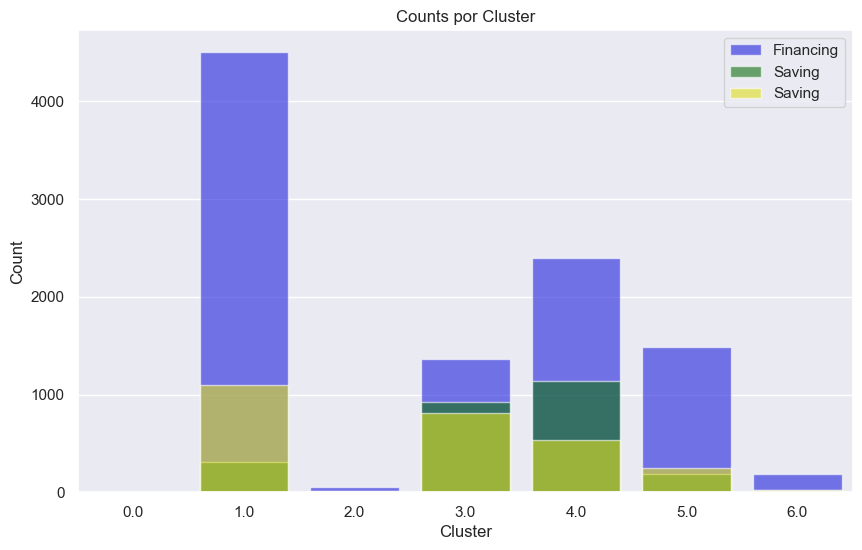

In [97]:
# Plotando o gráfico
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cluster_combined , x='cluster', y='increased_nr_financing_60_m+1', alpha=0.6, label='Financing', color="blue")
sns.barplot(data=df_cluster_combined , x='cluster', y='increased_nr_invest_savings_40_m+1', alpha=0.6, label='Saving', color="green")
sns.barplot(data=df_cluster_combined , x='cluster', y='increased_nr_accounts_10_m+1', alpha=0.6, label='Saving', color="yellow")

plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Counts por Cluster')
plt.legend()
plt.show()

In [98]:
#df_cluster_combined.to_pickle(FILEPATH_DATA_INPUT_PROCESSED+"df_grafico_ClusterxPropension.pkl")

In [99]:
df_emails["deceased"].value_counts()

0    9995
1       5
Name: deceased, dtype: int64

In [100]:
for col in df_emails.columns:
    print(col)

pk_cid
increased_nr_accounts_10_m+1
increased_nr_accounts_10_m+1_proba
ROI_nr_accounts_10_m+1
increased_nr_invest_savings_40_m+1
increased_nr_invest_savings_40_m+1_proba
ROI_nr_invest_savings_40_m+1
increased_nr_financing_60_m+1
increased_nr_financing_60_m+1_proba
ROI_nr_financing_60_m+1
ROI_margen_esperado_10
ROI_margen_esperado_40
ROI_margen_esperado_60
margen_esperado_max
pk_partition
entry_date
entry_channel
active_customer
segment
short_term_deposit
loans
mortgage
funds
securities
long_term_deposit
em_account_pp
credit_card
payroll
pension_plan
payroll_account
emc_account
debit_card
em_account_p
em_acount
country_id
region_code
gender
age
deceased
salary
age_cat
regions_ca_id
customer_acquisition_channel
nr_product
nr_accounts
nr_saving_and_investment
nr_financing
nr_product_max
nr_product_gap_to_max
nr_investment
product_mix_diversity
salary_CA
customer_tenure
digital_interaction_index
financial_health_score
entry_channel_salary
entry_channel_loyalty
periods_active
season
entry_d

In [101]:
# pk_cid
# increased_nr_accounts_10_m+1
# increased_nr_accounts_10_m+1_proba
# ROI_nr_accounts_10_m+1
# increased_nr_invest_savings_40_m+1
# increased_nr_invest_savings_40_m+1_proba
# ROI_nr_invest_savings_40_m+1
# increased_nr_financing_60_m+1
# increased_nr_financing_60_m+1_proba
# ROI_nr_financing_60_m+1
# ROI_margen_esperado_10
# ROI_margen_esperado_40
# ROI_margen_esperado_60
# margen_esperado_max
# pk_partition
# entry_date
# entry_channel
# active_customer
# segment
# short_term_deposit
# loans
# mortgage
# funds
# securities
# long_term_deposit
# em_account_pp
# credit_card
# payroll
# pension_plan
# payroll_account
# emc_account
# debit_card
# em_account_p
# em_acount
# country_id
# region_code
# gender
# age
# deceased
# salary
# age_cat
# regions_ca_id
# customer_acquisition_channel
# nr_product
# nr_accounts
# nr_saving_and_investment
# nr_financing
# nr_product_max
# nr_product_gap_to_max
# nr_investment
# product_mix_diversity
# salary_CA
# customer_tenure
# digital_interaction_index
# financial_health_score
# entry_channel_salary
# entry_channel_loyalty
# periods_active
# season
# entry_date_month
# entry_date_year
# working_day
# loan_utilization_index
# ES_Flag
# client_fidelity
# total_products
# nr_debt
# entry_channel_product
# channel_activity_level
# nr_product_trend
# nr_financing_60
# nr_invest_savings_40
# nr_account_10
# nr_financing_60_trend
# nr_invest_savings_40_trend
# nr_account_10_trend
# saving_behavior
# nr_risk_low
# nr_risk_medium
# nr_risk_high
# percent_risk_low
# percent_risk_medium
# percent_risk_high
# risk_index_absolute
# life_stage_indicator
# customer_lifetime_value_partition
# customer_lifetime_value_cumsum
# months_from_last_purchase
# date_last_purchase
# active_customer_rate
# months_from_last_purchase_digital
# date_last_purchase_digital
# total_products_ratio
# customer_acquisition_channel_min
# regions_cluster
# nr_transactions
# profit_60
# profit_40
# profit_10
# total_profit_customer
# cluster

·## Transformación con pipeline


In [102]:
df_emails.columns

Index(['pk_cid', 'increased_nr_accounts_10_m+1',
       'increased_nr_accounts_10_m+1_proba', 'ROI_nr_accounts_10_m+1',
       'increased_nr_invest_savings_40_m+1',
       'increased_nr_invest_savings_40_m+1_proba',
       'ROI_nr_invest_savings_40_m+1', 'increased_nr_financing_60_m+1',
       'increased_nr_financing_60_m+1_proba', 'ROI_nr_financing_60_m+1',
       ...
       'date_last_purchase_digital', 'total_products_ratio',
       'customer_acquisition_channel_min', 'regions_cluster',
       'nr_transactions', 'profit_60', 'profit_40', 'profit_10',
       'total_profit_customer', 'cluster'],
      dtype='object', length=101)

### Agrupamento de variables por naturaleza

In [103]:
#Variables originales
list_var_original=["pk_cid", 'pk_partition', 'entry_date', 'entry_channel', 'active_customer','segment', 'short_term_deposit', 'loans', 'mortgage', 'funds',
       'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account',
       'debit_card', 'em_account_p', 'em_acount', 'country_id', 'region_code', 'gender', 'age', 'deceased', 'salary']


#variables generadas
list_var_generated = ['age_cat', 'regions_ca_id',
       'customer_acquisition_channel', 'nr_product', 'nr_accounts',
       'nr_saving_and_investment', 'nr_financing', 'nr_product_max',
       'nr_product_gap_to_max', 'nr_investment', 'product_mix_diversity',
       'salary_CA', 'customer_tenure', 'digital_interaction_index',
       'financial_health_score', 'entry_channel_salary',
       'entry_channel_loyalty', 'periods_active', 'season', 'entry_date_month',
       'entry_date_year', 'working_day', 'loan_utilization_index', 'ES_Flag',
       'client_fidelity', 'total_products', 'nr_debt', 'entry_channel_product',
       'channel_activity_level', 'nr_product_trend', 'nr_financing_60',
       'nr_invest_savings_40', 'nr_account_10', 'nr_financing_60_trend',
       'nr_invest_savings_40_trend', 'nr_account_10_trend', 'saving_behavior',
       'nr_risk_low', 'nr_risk_medium', 'nr_risk_high', 'percent_risk_low',
       'percent_risk_medium', 'percent_risk_high', 'risk_index_absolute',
       'life_stage_indicator', 'customer_lifetime_value_partition',
       'customer_lifetime_value_cumsum', 'months_from_last_purchase',
       'date_last_purchase', 'active_customer_rate',
       'months_from_last_purchase_digital', 'date_last_purchase_digital',
       'total_products_ratio',"regions_cluster","customer_acquisition_channel_min"]


list_time = ['periods_active', 'entry_date_year', 'working_day']

#caracteristicas socio/demograficas
list_socio = ['age_cat', 'regions_ca_id',"regions_cluster", "life_stage_indicator",'salary_CA', 'ES_Flag' ]

list_marketing = ['customer_acquisition_channel',"customer_acquisition_channel_min", 'entry_channel_loyalty',
                  'entry_date_month','entry_channel_salary','entry_channel_product','channel_activity_level']

#Caracteristicas económicas
list_economics =['customer_lifetime_value_partition', 'customer_lifetime_value_cumsum','financial_health_score']

#Frecuencia de compra
list_frecuency = ['months_from_last_purchase_digital', 'date_last_purchase_digital','date_last_purchase', 'months_from_last_purchase']

#productos
list_prod = ['nr_product', 'nr_accounts', 'nr_saving_and_investment', 'nr_financing', 'nr_product_max','nr_product_gap_to_max', 'nr_investment', 
             'product_mix_diversity','nr_financing_60', 'nr_invest_savings_40', 'nr_account_10','nr_risk_low', 'nr_debt','total_products','total_products_ratio']

#clientes más activos/tendencia
list_trend = ['nr_financing_60_trend','nr_invest_savings_40_trend', 'nr_account_10_trend','nr_product_trend','season']

#tiempo/relacionamento = 
list_relationship = ['customer_tenure','client_fidelity']

#compoartamiento
list_behavior = ['loan_utilization_index','saving_behavior','nr_risk_medium', 'nr_risk_high', 'percent_risk_low',
       'percent_risk_medium', 'percent_risk_high', 'risk_index_absolute','active_customer_rate','digital_interaction_index']

len(list_time + list_socio + list_marketing + list_economics + list_frecuency + list_prod + list_trend + list_relationship + list_behavior) == len(list_var_generated)


True

In [104]:
set(list_var_generated) - set(list_time + list_socio + list_marketing + list_economics + list_frecuency + list_prod + list_trend + list_relationship + list_behavior)
set(list_time + list_socio + list_marketing + list_economics + list_frecuency + list_prod + list_trend + list_relationship + list_behavior) - set(list_var_generated) 

set()

### Selección de variables para clustering


In [105]:

# #Variables originales
# list_var_original=['pk_partition', 'entry_date', 'entry_channel', 'active_customer','segment', 'short_term_deposit', 'loans', 'mortgage', 'funds',
#        'securities', 'long_term_deposit', 'em_account_pp', 'credit_card', 'payroll', 'pension_plan', 'payroll_account', 'emc_account',
#        'debit_card', 'em_account_p', 'em_acount', 'country_id', 'region_code', 'gender', 'age', 'deceased', 'salary']

list_var_original_toCluster=['pk_cid','segment', 'age']

# #caracteristicas temporales
# list_time_toCluster = ['periods_active', 'entry_date_year', 'working_day']

list_time_toCluster = []

##caracteristicas socio/demograficas
#list_socio_toCluster = ['age_cat', 'regions_ca_id',"regions_cluster", "life_stage_indicator",'salary_CA', 'ES_Flag' ]

list_socio_toCluster = []


# #caracteristicas de marketing
# list_marketing_toCluster = ['customer_acquisition_channel',"customer_acquisition_channel_min", 'entry_channel_loyalty',
#                   'entry_date_month','entry_channel_salary','entry_channel_product','channel_activity_level']

list_marketing_toCluster = []

# #Caracteristicas económicas
# list_economics_toCluster =['customer_lifetime_value_partition', 'customer_lifetime_value_cumsum','financial_health_score',"total_profit_customer"]

list_economics_toCluster =['financial_health_score',"total_profit_customer"]

# #Frecuencia de compra
# list_frecuency_toCluster = ['months_from_last_purchase_digital', 'date_last_purchase_digital','date_last_purchase', 'months_from_last_purchase']

list_frecuency_toCluster = ['months_from_last_purchase']

# #productos
# list_prod_toCluster = ['nr_product', 'nr_accounts', 'nr_saving_and_investment', 'nr_financing', 'nr_product_max','nr_product_gap_to_max', 'nr_investment', 
#              'product_mix_diversity','nr_financing_60', 'nr_invest_savings_40', 'nr_account_10','nr_debt','total_products','total_products_ratio']

list_prod_toCluster = ['product_mix_diversity','nr_financing_60', 'nr_invest_savings_40', 'nr_account_10',"nr_debt"]

# #clientes más activos/tendencia
# list_trend_toCluster = ['nr_financing_60_trend','nr_invest_savings_40_trend', 'nr_account_10_trend','nr_product_trend','season']

list_trend_toCluster = ['nr_product_trend']

# #tiempo/relacionamento = 
# list_relationship_toCluster = ['customer_tenure','client_fidelity','nr_product_gap_to_max']

list_relationship_toCluster = ['customer_tenure',"nr_product_gap_to_max"]

#compoartamiento
# list_behavior_toCluster = ['loan_utilization_index','saving_behavior',"regions_cluster",'nr_risk_low','nr_risk_medium', 'nr_risk_high', 'percent_risk_low',
#        'percent_risk_medium', 'percent_risk_high','risk_index_absolute','active_customer_rate','digital_interaction_index']


list_behavior_toCluster = ["nr_transactions",'loan_utilization_index','saving_behavior', 'risk_index_absolute','active_customer_rate']

#Definición de la lista con variables selecionadas de cada grupo:
# list_var_toCluster = list_var_original_toCluster + list_time_toCluster + list_socio_toCluster + list_marketing_toCluster + list_economics_toCluster + list_frecuency_toCluster + list_prod_toCluster +\
# list_trend_toCluster + list_relationship_toCluster + list_behavior_toCluster


list_var_toCluster =["pk_cid", "segment","age","nr_transactions","customer_tenure", "months_from_last_purchase",
                     "active_customer_rate",
                     "saving_behavior","nr_product_gap_to_max","product_mix_diversity",
                     "ROI_margen_esperado_10","ROI_margen_esperado_40", "ROI_margen_esperado_60"]


# customer_lifetime_value_cumsum
# months_from_last_purchase
# date_last_purchase
# active_customer_rate
# months_from_last_purchase_digital
# date_last_purchase_digital
# total_products_ratio
# customer_acquisition_channel_min
# regions_cluster
# nr_transactions

In [106]:
df_capstone_clean_2_last_partition_for_cluster = df_emails[list_var_toCluster]

####Configurar Clustering

In [107]:
#df_capstone_clean_2_last_partition.drop('pk_partition', axis='columns',inplace=True)
df_capstone_clean_2_last_partition_for_cluster.set_index('pk_cid', drop=True, inplace=True)
df_capstone_clean_2_last_partition_for_cluster.rename_axis(None,inplace=True)
df_capstone_clean_2_last_partition_for_cluster.head()

,segment,age,nr_transactions,customer_tenure,months_from_last_purchase,active_customer_rate,saving_behavior,nr_product_gap_to_max,product_mix_diversity,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60
1454294,03 - UNIVERSITARIO,21,2.0,252,3,0.444444,0,1,0.083333,0.000000,0.000000,59.957900
1394148,02 - PARTICULARES,93,12.0,396,1,1.000000,0,1,0.083333,0.000000,0.000000,59.819230
1060165,03 - UNIVERSITARIO,27,1.0,1352,16,1.000000,1,1,0.177778,0.000000,0.000000,59.806809
1435125,02 - PARTICULARES,72,4.0,289,4,0.900000,0,1,0.138889,0.000000,0.000000,59.758555
1390071,02 - PARTICULARES,33,8.0,424,3,0.928571,0,1,0.083333,6.449317,31.225665,59.748770


In [108]:
listarNulos(df_capstone_clean_2_last_partition_for_cluster)

,Nulos,porcentaje


In [109]:
df_capstone_clean_2_last_partition_for_cluster.columns

Index(['segment', 'age', 'nr_transactions', 'customer_tenure',
       'months_from_last_purchase', 'active_customer_rate', 'saving_behavior',
       'nr_product_gap_to_max', 'product_mix_diversity',
       'ROI_margen_esperado_10', 'ROI_margen_esperado_40',
       'ROI_margen_esperado_60'],
      dtype='object')

In [110]:
lnum, lbool, lcat, ldate = obtener_lista_variables(df_capstone_clean_2_last_partition_for_cluster,"","")

segment
age
nr_transactions
customer_tenure
months_from_last_purchase
active_customer_rate
saving_behavior
nr_product_gap_to_max
product_mix_diversity
ROI_margen_esperado_10
ROI_margen_esperado_40
ROI_margen_esperado_60


In [111]:
print(f"Variables Numéricas: {lnum}")
print(f"Variables Booleanas: {lbool}")
print(f"Variables Categóricas: {lcat}")
print(f"Variables Fechas: {ldate}")


Variables Numéricas: ['age', 'nr_transactions', 'customer_tenure', 'months_from_last_purchase', 'active_customer_rate', 'saving_behavior', 'nr_product_gap_to_max', 'product_mix_diversity', 'ROI_margen_esperado_10', 'ROI_margen_esperado_40', 'ROI_margen_esperado_60']
Variables Booleanas: []
Variables Categóricas: ['segment']
Variables Fechas: []


In [112]:
if len(df_capstone_clean_2_last_partition_for_cluster.columns) - (len(lnum) + len(lbool) + len(lcat) + len(ldate)) == 0:
    print('Todas las columnas incluídas en las listas de variables')
else:
    print('Revisar, no todas las columnas están incluídas')
    print(f'{len(df_capstone_clean_2_last_partition_for_cluster.columns) - (len(lnum) + len(lbool) + len(lcat) + len(ldate))}')

Todas las columnas incluídas en las listas de variables


In [113]:
scale_pipe = ColumnTransformer(
    transformers = [
            ("scale_numeric_columns", RobustScaler(quantile_range = (10.0, 99.0)), lnum),
        ],
    remainder='passthrough',
    verbose_feature_names_out = False
)

#df_capstone = scale_pipe.fit_transform(df_capstone)

In [114]:
print(lcat)

['segment']


In [115]:
for i in lcat:
    print(f'{i}: {df_capstone_clean_2_last_partition_for_cluster[i].nunique()}')

segment: 3


In [116]:
#segment_labels = [['03 - UNIVERSITARIO', '02 - PARTICULARES', '01 - TOP']]

encode_pipe = ColumnTransformer(
    transformers = [
            ("oe_cat", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), lcat),
            #("orde_cat", OrdinalEncoder(categories=segment_labels), lcat)
        ],
    remainder='passthrough',
    verbose_feature_names_out = False
)

#df_capstone = encode.fit_transform(df_capstone)

In [117]:
pipe = Pipeline(
    steps = [
        ("scaler", scale_pipe),
        ("encoder",encode_pipe),
    ]
)

pipe

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale_numeric_columns',
                                                  RobustScaler(quantile_range=(10.0,
                                                                               99.0)),
                                                  ['age', 'nr_transactions',
                                                   'customer_tenure',
                                                   'months_from_last_purchase',
                                                   'active_customer_rate',
                                                   'saving_behavior',
                                                   'nr_product_gap_to_max',
                                                   'product_mix_diversity',
                                                   'ROI_margen_esperado_10',
                                                   'ROI_margen_esperado_40',
                                                   'ROI_margen_esperado_60'])],
                                   verbose_feature_names_out=False)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oe_cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['segment'])],
                                   verbose_feature_names_out=False))])

In [118]:
df_capstone_clean_2_last_partition_for_cluster_scaled_transformed = pipe.fit_transform(df_capstone_clean_2_last_partition_for_cluster)

In [119]:
df_capstone_clean_2_last_partition_for_cluster_scaled_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1454294 to 1183407
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   segment_01 - TOP            10000 non-null  float64
 1   segment_02 - PARTICULARES   10000 non-null  float64
 2   segment_03 - UNIVERSITARIO  10000 non-null  float64
 3   age                         10000 non-null  float64
 4   nr_transactions             10000 non-null  float64
 5   customer_tenure             10000 non-null  float64
 6   months_from_last_purchase   10000 non-null  float64
 7   active_customer_rate        10000 non-null  float64
 8   saving_behavior             10000 non-null  float64
 9   nr_product_gap_to_max       10000 non-null  float64
 10  product_mix_diversity       10000 non-null  float64
 11  ROI_margen_esperado_10      10000 non-null  float64
 12  ROI_margen_esperado_40      10000 non-null  float64
 13  ROI_margen_esperado_60 

In [120]:
df_capstone_clean_2_last_partition_for_cluster_scaled_transformed.head().T

,1454294,1394148,1060165,1435125,1390071
segment_01 - TOP,0.000000,0.000000,0.000000,0.000000,0.000000
segment_02 - PARTICULARES,0.000000,1.000000,0.000000,1.000000,1.000000
segment_03 - UNIVERSITARIO,1.000000,0.000000,1.000000,0.000000,0.000000
age,-0.239130,1.326087,-0.108696,0.869565,0.021739
nr_transactions,-0.235294,0.352941,-0.294118,-0.117647,0.117647
customer_tenure,-0.446925,-0.341508,0.358346,-0.419839,-0.321010
months_from_last_purchase,0.090909,-0.090909,1.272727,0.181818,0.090909
active_customer_rate,-1.349206,0.000000,0.000000,-0.242857,-0.173469
saving_behavior,0.000000,0.000000,0.500000,0.000000,0.000000
nr_product_gap_to_max,0.000000,0.000000,0.000000,0.000000,0.000000


In [121]:
df_capstone_clean_2_last_partition_for_cluster_scaled_transformed.isnull().sum().sum()

0

### Analisis de dispersión ("codo" K)

Ya esta definido com 7,8 por el enunciado del problema.
Hemos elegido 7. 

In [122]:
sse = {}

for k in range(1, 6):

    print(f"Fitting pipe with {k} clusters")

    clustering_model = KMeans(n_clusters = k)
    clustering_model.fit(df_capstone_clean_2_last_partition_for_cluster_scaled_transformed)

    sse[k] = clustering_model.inertia_

Fitting pipe with 1 clusters
Fitting pipe with 2 clusters
Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters


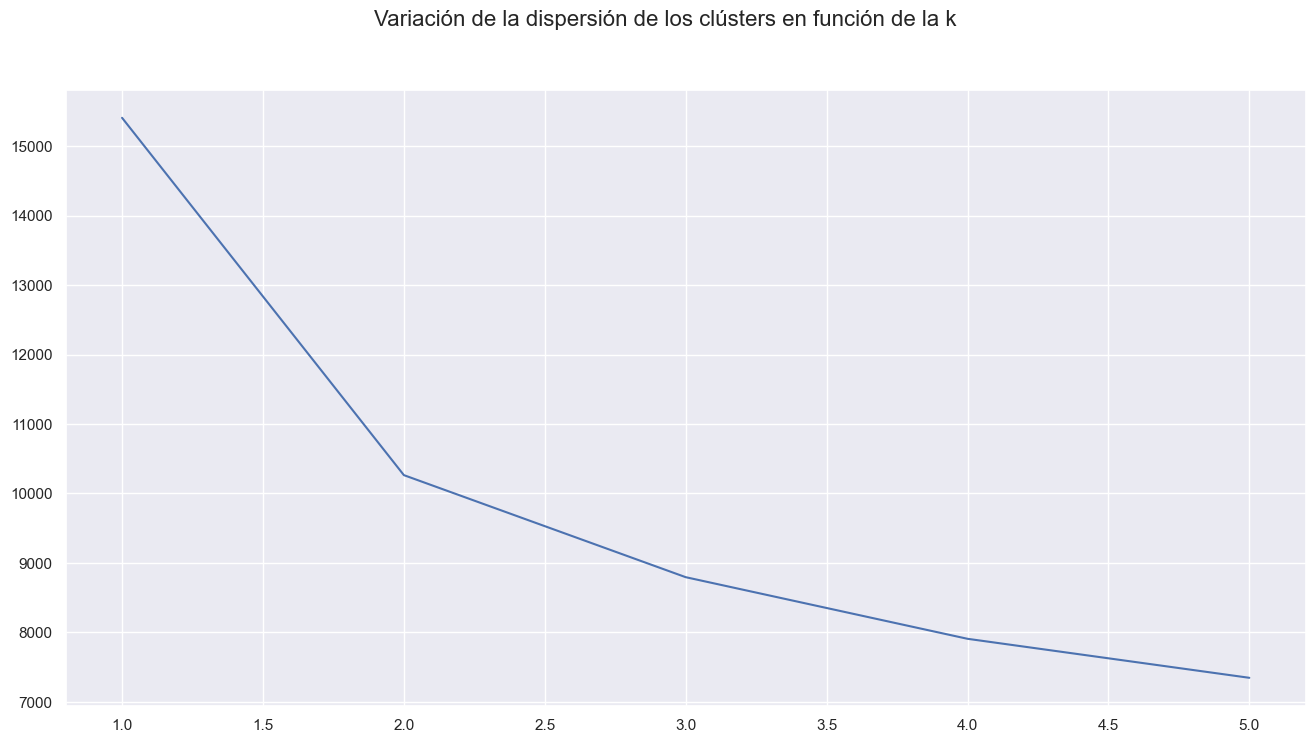

In [123]:
fig = plt.figure(figsize = (16, 8))
ax = fig.add_subplot()

x_values = list(sse.keys())
y_values = list(sse.values())

ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 16);

### Aplicación de Kmeans con k=7

In [124]:
pipe_KMeans = Pipeline(steps = [
    ("Clustering", KMeans(n_clusters = 4, random_state = 175))
])

In [125]:
pipe_KMeans.fit(df_capstone_clean_2_last_partition_for_cluster_scaled_transformed)

Pipeline(steps=[('Clustering', KMeans(n_clusters=4, random_state=175))])

In [126]:
pipe_KMeans[0].cluster_centers_.shape

(4, 14)

In [127]:
pipe_KMeans[0].cluster_centers_[0]

array([ 1.32988548e-02,  9.86701145e-01, -1.66533454e-16,  2.19712179e-01,
        4.93926422e-02, -2.07754041e-02,  7.00204856e-02, -8.19847434e-02,
        1.88400443e-02,  1.10177318e-01, -1.54728875e-01,  2.83132076e-01,
        2.81481224e-01,  1.85290515e-01])

In [128]:
X_results = pipe_KMeans.transform(df_capstone_clean_2_last_partition_for_cluster_scaled_transformed)

In [129]:
X_results.head(4)

,kmeans0,kmeans1,kmeans2,kmeans3
1454294,2.104631,1.051777,1.608743,2.170683
1394148,1.346247,2.520192,2.236238,1.572681
1060165,2.115539,2.239298,1.503216,2.088003
1435125,1.011110,2.097382,1.957128,1.195876


In [130]:
labels = pipe_KMeans.predict(df_capstone_clean_2_last_partition_for_cluster_scaled_transformed)

In [131]:
len(labels)

10000

In [132]:
df_capstone_clean_2_last_partition_for_cluster_with_labels = df_capstone_clean_2_last_partition_for_cluster

In [133]:
pipe

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scale_numeric_columns',
                                                  RobustScaler(quantile_range=(10.0,
                                                                               99.0)),
                                                  ['age', 'nr_transactions',
                                                   'customer_tenure',
                                                   'months_from_last_purchase',
                                                   'active_customer_rate',
                                                   'saving_behavior',
                                                   'nr_product_gap_to_max',
                                                   'product_mix_diversity',
                                                   'ROI_margen_esperado_10',
                                                   'ROI_margen_esperado_40',
                                                   'ROI_margen_esperado_60'])],
                                   verbose_feature_names_out=False)),
                ('encoder',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('oe_cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['segment'])],
                                   verbose_feature_names_out=False))])

In [134]:
pipe[1]

ColumnTransformer(remainder='passthrough',
                  transformers=[('oe_cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['segment'])],
                  verbose_feature_names_out=False)

In [135]:
df_capstone_clean_2_last_partition_for_cluster_with_labels = pipe[1].transform(df_capstone_clean_2_last_partition_for_cluster_with_labels)

In [136]:
# le asignamos al DataFrame procesado el clúster.
# si lo hacemos al df escalado será más díficil de interpretar los resultados porque los números están escalados

df_capstone_clean_2_last_partition_for_cluster_with_labels["cluster"] = labels

In [137]:
df_capstone_clean_2_last_partition_for_cluster_with_labels.head()

,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,age,nr_transactions,customer_tenure,months_from_last_purchase,active_customer_rate,saving_behavior,nr_product_gap_to_max,product_mix_diversity,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,cluster
1454294,0.0,0.0,1.0,21,2.0,252,3,0.444444,0,1,0.083333,0.000000,0.000000,59.957900,1
1394148,0.0,1.0,0.0,93,12.0,396,1,1.000000,0,1,0.083333,0.000000,0.000000,59.819230,0
1060165,0.0,0.0,1.0,27,1.0,1352,16,1.000000,1,1,0.177778,0.000000,0.000000,59.806809,2
1435125,0.0,1.0,0.0,72,4.0,289,4,0.900000,0,1,0.138889,0.000000,0.000000,59.758555,0
1390071,0.0,1.0,0.0,33,8.0,424,3,0.928571,0,1,0.083333,6.449317,31.225665,59.748770,0


In [138]:
df_capstone_clean_2_last_partition_for_cluster_with_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1454294 to 1183407
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   segment_01 - TOP            10000 non-null  float64
 1   segment_02 - PARTICULARES   10000 non-null  float64
 2   segment_03 - UNIVERSITARIO  10000 non-null  float64
 3   age                         10000 non-null  int64  
 4   nr_transactions             10000 non-null  float64
 5   customer_tenure             10000 non-null  int64  
 6   months_from_last_purchase   10000 non-null  int64  
 7   active_customer_rate        10000 non-null  float64
 8   saving_behavior             10000 non-null  int64  
 9   nr_product_gap_to_max       10000 non-null  int64  
 10  product_mix_diversity       10000 non-null  float64
 11  ROI_margen_esperado_10      10000 non-null  float64
 12  ROI_margen_esperado_40      10000 non-null  float64
 13  ROI_margen_esperado_60 

In [139]:
pd.set_option('display.max_columns', None)

df_capstone_clean_2_last_partition_for_cluster_with_labels.head()

,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,age,nr_transactions,customer_tenure,months_from_last_purchase,active_customer_rate,saving_behavior,nr_product_gap_to_max,product_mix_diversity,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,cluster
1454294,0.0,0.0,1.0,21,2.0,252,3,0.444444,0,1,0.083333,0.000000,0.000000,59.957900,1
1394148,0.0,1.0,0.0,93,12.0,396,1,1.000000,0,1,0.083333,0.000000,0.000000,59.819230,0
1060165,0.0,0.0,1.0,27,1.0,1352,16,1.000000,1,1,0.177778,0.000000,0.000000,59.806809,2
1435125,0.0,1.0,0.0,72,4.0,289,4,0.900000,0,1,0.138889,0.000000,0.000000,59.758555,0
1390071,0.0,1.0,0.0,33,8.0,424,3,0.928571,0,1,0.083333,6.449317,31.225665,59.748770,0


In [140]:
df_capstone_clean_2_last_partition_for_cluster_with_labels.describe()

,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,age,nr_transactions,customer_tenure,months_from_last_purchase,active_customer_rate,saving_behavior,nr_product_gap_to_max,product_mix_diversity,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,cluster
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,0.024400,0.560400,0.415200,34.779600,6.343400,830.475600,2.660500,0.906938,0.472200,0.910400,0.142752,1.883644,6.981746,55.260244,1.65340
std,0.154295,0.496363,0.492781,11.322175,4.075186,427.496613,2.476056,0.204987,0.545946,0.843826,0.074155,3.167712,12.077754,2.509059,1.15793
min,0.000000,0.000000,0.000000,20.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,51.218852,0.00000
25%,0.000000,0.000000,0.000000,26.000000,3.000000,504.000000,1.000000,0.941176,0.000000,0.000000,0.083333,0.000000,0.000000,53.036873,0.00000
50%,0.000000,1.000000,0.000000,32.000000,6.000000,862.500000,2.000000,1.000000,0.000000,1.000000,0.138889,0.000000,0.000000,55.107012,2.00000
75%,0.000000,1.000000,1.000000,41.000000,9.000000,1220.000000,3.000000,1.000000,1.000000,1.000000,0.177778,5.201179,20.374069,57.346545,3.00000
max,1.000000,1.000000,1.000000,97.000000,29.000000,1607.000000,16.000000,1.000000,4.000000,6.000000,0.516667,9.960269,39.876070,59.957900,3.00000


### Definición de Ficha de Cliente 

In [141]:
ficha_df = pd.DataFrame()

# for i, col in enumerate(["age", "salary", "segment_01 - TOP", "segment_02 - PARTICULARES", "segment_03 - UNIVERSITARIO", "periods_active", "customer_tenure", "entry_date_month", "months_from_last_purchase", "digital_interaction_index", "financial_health_score", "saving_behavior", "risk_index_absolute", "nr_accounts", "nr_investment", "nr_debt", "clients_losing_fidelity", "product_mix_diversity_greater_than_75_percentile", "entry_channel_loyalty"]):
#     resumen_data = df_capstone_clean_2_last_partition_for_cluster_with_labels[["cluster", col]].groupby("cluster").describe().T[1:].round(4)
#     #ficha_df = ficha_df.append(resumen_data)
#     ficha_df = pd.concat([ficha_df, resumen_data])

cols = df_capstone_clean_2_last_partition_for_cluster_with_labels.columns.tolist()
cols.remove("cluster")
for i, col in enumerate(cols):
    #resumen_data = df_capstone_clean_2_last_partition_for_cluster_with_labels[["cluster", col]].groupby("cluster").describe().T[1:].round(4)
    resumen_data = df_capstone_clean_2_last_partition_for_cluster_with_labels[["cluster", col]].groupby("cluster").describe().T[1:].round(4)
    #ficha_df = ficha_df.append(resumen_data)
    ficha_df = pd.concat([ficha_df, resumen_data])

In [142]:
# generamos nuestro multiindex
out_index = [
"Segmento (social)",
"Segmento (social)",
"Segmento (social)",
"Edad",
"Relacionamiento",
"Relacionamiento",
"Frecuencia",
"Comportamiento",
"Comportamiento",
"Comportamiento",
"Productos",
"Productos",
"Productos",
"Productos",
]


inner_index = [
"Top", 
"Particulares", 
"Universitario", 
"Edad", 
"Transaciones",
"Tenencia del cliente", 
"Meses desde la ultima compra",
"Digtitalización - índice",
"Comportamiento Ahorro",
"GAP de fidelización", 
"Diversificación de Productos",
"ROI experado Cuentas EasyMoney",
'ROI esperado Inversiones y ahorro',
"ROI esperado Financiación"]

estadisticos = ["Media", "Desviación", "Mínimo", "Perc. 25", "Perc. 50", "Perc. 75", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))

In [143]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)
index_ficha

MultiIndex([('Segmento (social)',                               'Top', ...),
            ('Segmento (social)',                               'Top', ...),
            ('Segmento (social)',                               'Top', ...),
            ('Segmento (social)',                               'Top', ...),
            ('Segmento (social)',                               'Top', ...),
            ('Segmento (social)',                               'Top', ...),
            ('Segmento (social)',                               'Top', ...),
            ('Segmento (social)',                      'Particulares', ...),
            ('Segmento (social)',                      'Particulares', ...),
            ('Segmento (social)',                      'Particulares', ...),
            ('Segmento (social)',                      'Particulares', ...),
            ('Segmento (social)',                      'Particulares', ...),
            ('Segmento (social)',                      'Particulares', ...),

In [144]:
tamaño_clusters = df_capstone_clean_2_last_partition_for_cluster_with_labels.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)
tamaño_clusters

,,cluster,0,1,2,3
Grupo Indicadores,Indicador,Estadístico,,,,
General,Clúster,Tamaño,2707,916,3513,2864


In [145]:
ficha_df = pd.concat([tamaño_clusters, ficha_df])
ficha_df

cluster                                                          0         1  \
Grupo Indicadores Indicador                 Estadístico                        
General           Clúster                   Tamaño       2707.0000  916.0000   
Segmento (social) Top                       Media           0.0133    0.0022   
                                            Desviación      0.1146    0.0467   
                                            Mínimo          0.0000    0.0000   
                                            Perc. 25        0.0000    0.0000   
...                                                            ...       ...   
Productos         ROI esperado Financiación Mínimo         51.2228   51.2207   
                                            Perc. 25       54.7545   52.3830   
                                            Perc. 50       57.1194   53.7403   
                                            Perc. 75       58.8431   55.9147   
                                            Máximo         59.8192   59.9579   

cluster                                                          2          3  
Grupo Indicadores Indicador                 Estadístico                        
General           Clúster                   Tamaño       3513.0000  2864.0000  
Segmento (social) Top                       Media           0.0009     0.0709  
                                            Desviación      0.0292     0.2567  
                                            Mínimo          0.0000     0.0000  
                                            Perc. 25        0.0000     0.0000  
...                                                            ...        ...  
Productos         ROI esperado Financiación Mínimo         51.2189    51.2189  
                                            Perc. 25       52.6551    53.1674  
                                            Perc. 50       54.3439    54.7108  
                                            Perc. 75       56.6848    56.9260  
                                            Máximo         59.8068    59.7484  

[99 rows x 4 columns]

In [146]:
ficha_df = ficha_df.rename(columns = {
    0: "Profesionales con alta actividad transaccional y tenencia, pero con baja diversificación de productos y dificultad para ahorrar",
    1: "Estudiantes con alta tenencia y un comportamiento medio de ahorro, pero con baja actividad digital y transaccional",
    2: "Estudiantes con alta tenencia y actividad digital, pero poco activos en compras recientes y con necesidad de orientación financiera",
    3: "Profesionales altamente activos y diversificados en productos, con un alto comportamiento de ahorro y muy activos digitalmente",

})




### Ficha Cliente 

In [147]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

### Ficha Cliente Resumida (media)

In [148]:
#Generar ficha resumida

def highlight_min_rowwise(s):
    is_min = s == s.min()
    return ['background-color: red' if v else '' for v in is_min]

indices_mean = ficha_df[ficha_df.index.get_level_values(2).str.contains("Me")].index
ficha_df.loc[indices_mean].style.background_gradient(cmap='Blues', axis=1).apply(highlight_min_rowwise, axis=1)

### Informe: Perfil del cliente en cada cluster

Te paso aqui el texto, por si quieres copiarlo en tu notebook:

| Cluster | Nombre del Cluster                    | Descripción                                                                                           | Perfil                                                                                                                     | Puntos Fuertes                                                                              | Puntos Débiles                                                                       | Persona                                              | Dificultades                                 | Oportunidades                                                                                      |
|---------|--------------------------------------|-------------------------------------------------------------------------------------------------------|----------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------|------------------------------------------------------|----------------------------------------------|----------------------------------------------------------------------------------------------------|
| 0       | "El Profesional Tradicionalista"  | Profesionales con alta actividad transaccional y tenencia, pero con baja diversificación de productos y dificultad para ahorrar.     | Mayoría del segmento "PARTICULARES". Edad promedio más alta (+-42 años). Baja diversidad de productos. | Alto número de transacciones (el segmento que más). Alta actividad digital. Alta tenencia.         | Muy baja diversificación de productos. Bajo comportamiento de ahorro. Alto gap de fidelización (el segmento que más). Actividad media (varios meses desde la ultima compra).  | Profesionales.      | Dificultad para ahorrar.               | Oportunidad alta de ofrecerle las 3 familias de productos (ROI el más alto en las 3 familias). Ofrecer productos de financiamiento (préstamos y tarjetas) adaptados a profesionales. También interesados en productos de inversión y ahorro. Fidelizar. Bastantes meses desde la última compra.                     |
| 1       | "El Estudiante Ahorrador Incipiente"  | Estudiantes con alta tenencia y un comportamiento medio de ahorro, pero con baja actividad digital y transaccional.                                            | Predominantemente del segmento "UNIVERSITARIOS".  Edad promedio media (+-29 años).        |  Alta tenencia. Comportamiento medio de ahorro. Bajo gap de fidelización.            | Bajo número de transacciones. Baja actividad digital (el que menos). Actividad media (varios meses desde la ultima compra). Baja diversificación de productos.            |           | Necesidad de educación financiera.  | Ofrecer productos de financiamiento (préstamos y tarjetas) adaptados a estudiantes. También interesados en productos de inversión y ahorro.                                                     | 
| 2       |  "El Universitario Digitalmente Activo"  | Estudiantes con alta tenencia y actividad digital, pero poco activos en compras recientes y con necesidad de orientación financiera.                         | Mayoría del segmento "UNIVERSITARIOS". Edad promedio baja (+-26 años).                                        | Alto número de transacciones. Alta tenencia (el segmento que más).  Alta actividad digital. Comportamiento medio de ahorro.                                                                  | Muy poco activo (muchos meses desde la ultima compra). Alto gap de fidelización. Baja diversificación de productos.      | . | Necesidad de orientación financiera para maximizar el potencial de inversión.                   | Ofrecer productos de financiamiento (préstamos y tarjetas) adaptados a estudiantes. También interesados en productos de inversión y ahorro.|
| 3       | "El Profesional Diversificado Activo"        |   Profesionales altamente activos y diversificados en productos, con un alto comportamiento de ahorro y muy activos digitalmente.               | Mayoría del segmento "PARTICULARES". Mayor representatividad del segmento TOP. Edad promedio alta (+-39 años).                    | Alto número de transacciones. Muy activo (pocos meses desde la última compra).  Alta actividad digital. Alto comportamiento de ahorro. Muy bajo gap de fidelizacion. Muy alta diversificación de productos.  | Muy baja tenencia.                                |  | Necesidad de servicios de consultoría financiera personalizada.  | Ofrecer productos de financiamiento (préstamos y tarjetas) adaptados a profesionales. También interesados en cuentas Easy Money.            |

### Graficos: Perfil del cliente en cada cluster

In [149]:
# Aplicación de escalado MinMax para que se pueda realizar comparaciones entre los perfiles
x= ficha_df.loc[indices_mean].reset_index().drop(columns=["Grupo Indicadores","Estadístico" ])
x.set_index("Indicador", inplace=True)
x =x.T

scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
df_normalized_T = df_normalized.T

#Reducir variables para el gráfico de radar
cols_gra = set(df_normalized_T.index) - set(["Préstamos - índice","Salud Financiera","Ganáncia Total Generada","Tenencia del cliente", "Comportamiento Ahorro"])
df_normalized_T = df_normalized_T.loc[cols_gra]

#Generar graficos

generar_grafico_radar(df_normalized_T.index, df_normalized_T[df_normalized_T.columns[0]],"Cluster 0","green")

In [150]:
generar_grafico_radar(df_normalized_T.index, df_normalized_T[df_normalized_T.columns[1]],"Cluster 1","blue")

In [151]:
generar_grafico_radar(df_normalized_T.index, df_normalized_T[df_normalized_T.columns[2]],"Cluster 2","seagreen")

In [152]:
generar_grafico_radar(df_normalized_T.index, df_normalized_T[df_normalized_T.columns[3]],"Cluster 3","red")


array([[<Axes: title={'center': 'cluster'}>,
        <Axes: title={'center': 'value'}>]], dtype=object)

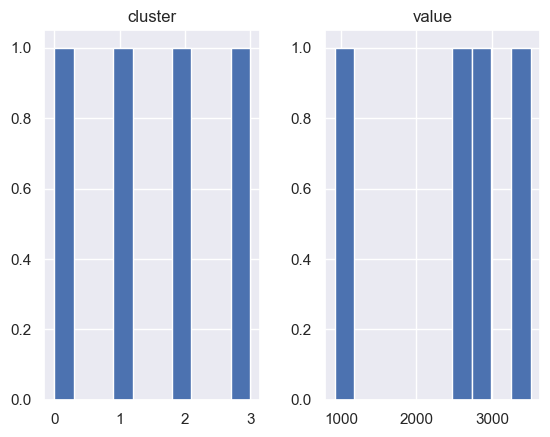

In [153]:
hist = ficha_df.iloc[:1].melt()
hist["cluster"] = [0,1,2,3]
hist.hist()

In [154]:
ficha_df.to_pickle(FILEPATH_DATA_INPUT_PROCESSED+"ficha_df_CUSTOMIZATION.pkl.gz", compression='gzip')
df_capstone_clean_2_last_partition_for_cluster_with_labels.to_pickle(FILEPATH_DATA_INPUT_PROCESSED+"df_clusters_CUSTOMIZATION.pkl.gz", compression='gzip')

In [159]:
df_capstone_clean_2_last_partition_for_cluster_with_labels

,segment_01 - TOP,segment_02 - PARTICULARES,segment_03 - UNIVERSITARIO,age,nr_transactions,customer_tenure,months_from_last_purchase,active_customer_rate,saving_behavior,nr_product_gap_to_max,product_mix_diversity,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,cluster
1454294,0.0,0.0,1.0,21,2.0,252,3,0.444444,0,1,0.083333,0.000000,0.000000,59.957900,1
1394148,0.0,1.0,0.0,93,12.0,396,1,1.000000,0,1,0.083333,0.000000,0.000000,59.819230,0
1060165,0.0,0.0,1.0,27,1.0,1352,16,1.000000,1,1,0.177778,0.000000,0.000000,59.806809,2
1435125,0.0,1.0,0.0,72,4.0,289,4,0.900000,0,1,0.138889,0.000000,0.000000,59.758555,0
1390071,0.0,1.0,0.0,33,8.0,424,3,0.928571,0,1,0.083333,6.449317,31.225665,59.748770,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1065497,0.0,0.0,1.0,31,1.0,1342,5,0.352941,0,0,0.083333,0.000000,0.000000,51.220726,1
1388145,1.0,0.0,0.0,66,2.0,437,0,1.000000,0,0,0.138889,7.897163,0.000000,51.219742,3
1157334,0.0,0.0,1.0,32,7.0,1026,0,1.000000,1,0,0.177778,0.000000,0.000000,51.219492,2
1014572,1.0,0.0,0.0,62,9.0,1485,4,1.000000,1,1,0.261111,5.410486,20.718362,51.218902,3


In [160]:
df_emails.shape

(10000, 101)

In [161]:
df_emails

,pk_cid,increased_nr_accounts_10_m+1,increased_nr_accounts_10_m+1_proba,ROI_nr_accounts_10_m+1,increased_nr_invest_savings_40_m+1,increased_nr_invest_savings_40_m+1_proba,ROI_nr_invest_savings_40_m+1,increased_nr_financing_60_m+1,increased_nr_financing_60_m+1_proba,ROI_nr_financing_60_m+1,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,margen_esperado_max,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,age_cat,regions_ca_id,customer_acquisition_channel,nr_product,nr_accounts,nr_saving_and_investment,nr_financing,nr_product_max,nr_product_gap_to_max,nr_investment,product_mix_diversity,salary_CA,customer_tenure,digital_interaction_index,financial_health_score,entry_channel_salary,entry_channel_loyalty,periods_active,season,entry_date_month,entry_date_year,working_day,loan_utilization_index,ES_Flag,client_fidelity,total_products,nr_debt,entry_channel_product,channel_activity_level,nr_product_trend,nr_financing_60,nr_invest_savings_40,nr_account_10,nr_financing_60_trend,nr_invest_savings_40_trend,nr_account_10_trend,saving_behavior,nr_risk_low,nr_risk_medium,nr_risk_high,percent_risk_low,percent_risk_medium,percent_risk_high,risk_index_absolute,life_stage_indicator,customer_lifetime_value_partition,customer_lifetime_value_cumsum,months_from_last_purchase,date_last_purchase,active_customer_rate,months_from_last_purchase_digital,date_last_purchase_digital,total_products_ratio,customer_acquisition_channel_min,regions_cluster,nr_transactions,profit_60,profit_40,profit_10,total_profit_customer,cluster
0,1454294,0,0.002202,0.000000,0,0.004779,0.000000,1,0.999298,59.957900,0.000000,0.000000,59.957900,59.957900,2019-05-28,2018-09-18,KHQ,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,21.0,H,21,0,38513.97,"(20.0, 30.0]",AN,KH,1,1,0,0,2,1,0,0.083333,11977.0,252,1.00,0.000666,97521.064767,249.517699,4,Low_Season,9,2018,1,0,1,losing_fidelity,1,1,em_acount,0.302375,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Adulto Joven,-60.0,10.0,3,2019-02-28,0.444444,3,2019-02-28,0.066667,Prefix,AN,2.0,60.0,0.0,0.0,60.0,6.0
1,1394148,0,0.184762,0.000000,0,0.021956,0.000000,1,0.996987,59.819230,0.000000,0.000000,59.819230,59.819230,2019-05-28,2018-04-27,KHK,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,45.0,V,93,0,42671.28,"(90.0, inf]",CM,KH,1,1,0,0,2,1,0,0.083333,15129.0,396,1.00,0.000738,110141.452954,471.405757,14,Low_Season,4,2018,1,0,1,losing_fidelity,1,1,em_acount,0.639291,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Anciano+,-60.0,10.0,1,2019-04-28,1.000000,1,2019-04-28,0.066667,Prefix,Otros,12.0,360.0,0.0,0.0,360.0,3.0
2,1060165,0,0.420864,0.000000,0,0.003649,0.000000,1,0.996780,59.806809,0.000000,0.000000,59.806809,59.806809,2019-05-28,2015-09-14,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,ES,3.0,V,27,0,70929.06,"(20.0, 30.0]",VC,KH,3,0,1,2,4,1,1,0.177778,13643.0,1352,0.00,0.167894,108529.905617,964.341855,17,Low_Season,9,2015,1,0,1,losing_fidelity,3,1,payroll,0.253152,-1.0,0,1,2,-1.0,0.0,0.0,1,3,0,0,0.333333,0.0,0.0,1,Adulto Joven,-60.0,60.0,16,2018-01-28,1.000000,16,2018-01-28,0.200000,Prefix,VC,1.0,0.0,0.0,0.0,0.0,1.0
3,1435125,0,0.358099,0.000000,0,0.286869,0.000000,1,0.995976,59.758555,0.000000,0.000000,59.758555,59.758555,2019-05-28,2018-08-12,KHM,1,02 - PARTICULARES,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,ES,8.0,H,72,0,183746.82,"(70.0, 80.0]",CT,KH,2,1,0,1,3,1,0,0.138889,17459.0,289,0.50,0.003180,100706.027824,192.100628,9,Low_Season,8,2018,0,0,1,losing_fidelity,2,2,em_acount,0.635886,-1.0,1,0,1,-1.0,0.0,0.0,0,1,0,1,0.111111,0.0,0.2,3,Anciano,-60.0,70.0,4,2019-01-28,0.900000,4,2019-01-28,0.133333,Prefix,CT,4.0,120.0,0.0,10.0,130.0,3.0
4,1390071,1,0.644932,6.449317,1,0.780642,31.225665,1,0.995813,59.748770,6.449317,31.225665,59.748770,59.748770,2019-05-28,2

In [162]:
df_emails.rename(columns={"cluster":"cluster_SEGMENTATION"}, inplace=True)

In [163]:
df_emails

,pk_cid,increased_nr_accounts_10_m+1,increased_nr_accounts_10_m+1_proba,ROI_nr_accounts_10_m+1,increased_nr_invest_savings_40_m+1,increased_nr_invest_savings_40_m+1_proba,ROI_nr_invest_savings_40_m+1,increased_nr_financing_60_m+1,increased_nr_financing_60_m+1_proba,ROI_nr_financing_60_m+1,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,margen_esperado_max,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,age_cat,regions_ca_id,customer_acquisition_channel,nr_product,nr_accounts,nr_saving_and_investment,nr_financing,nr_product_max,nr_product_gap_to_max,nr_investment,product_mix_diversity,salary_CA,customer_tenure,digital_interaction_index,financial_health_score,entry_channel_salary,entry_channel_loyalty,periods_active,season,entry_date_month,entry_date_year,working_day,loan_utilization_index,ES_Flag,client_fidelity,total_products,nr_debt,entry_channel_product,channel_activity_level,nr_product_trend,nr_financing_60,nr_invest_savings_40,nr_account_10,nr_financing_60_trend,nr_invest_savings_40_trend,nr_account_10_trend,saving_behavior,nr_risk_low,nr_risk_medium,nr_risk_high,percent_risk_low,percent_risk_medium,percent_risk_high,risk_index_absolute,life_stage_indicator,customer_lifetime_value_partition,customer_lifetime_value_cumsum,months_from_last_purchase,date_last_purchase,active_customer_rate,months_from_last_purchase_digital,date_last_purchase_digital,total_products_ratio,customer_acquisition_channel_min,regions_cluster,nr_transactions,profit_60,profit_40,profit_10,total_profit_customer,cluster_SEGMENTATION
0,1454294,0,0.002202,0.000000,0,0.004779,0.000000,1,0.999298,59.957900,0.000000,0.000000,59.957900,59.957900,2019-05-28,2018-09-18,KHQ,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,21.0,H,21,0,38513.97,"(20.0, 30.0]",AN,KH,1,1,0,0,2,1,0,0.083333,11977.0,252,1.00,0.000666,97521.064767,249.517699,4,Low_Season,9,2018,1,0,1,losing_fidelity,1,1,em_acount,0.302375,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Adulto Joven,-60.0,10.0,3,2019-02-28,0.444444,3,2019-02-28,0.066667,Prefix,AN,2.0,60.0,0.0,0.0,60.0,6.0
1,1394148,0,0.184762,0.000000,0,0.021956,0.000000,1,0.996987,59.819230,0.000000,0.000000,59.819230,59.819230,2019-05-28,2018-04-27,KHK,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,45.0,V,93,0,42671.28,"(90.0, inf]",CM,KH,1,1,0,0,2,1,0,0.083333,15129.0,396,1.00,0.000738,110141.452954,471.405757,14,Low_Season,4,2018,1,0,1,losing_fidelity,1,1,em_acount,0.639291,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Anciano+,-60.0,10.0,1,2019-04-28,1.000000,1,2019-04-28,0.066667,Prefix,Otros,12.0,360.0,0.0,0.0,360.0,3.0
2,1060165,0,0.420864,0.000000,0,0.003649,0.000000,1,0.996780,59.806809,0.000000,0.000000,59.806809,59.806809,2019-05-28,2015-09-14,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,ES,3.0,V,27,0,70929.06,"(20.0, 30.0]",VC,KH,3,0,1,2,4,1,1,0.177778,13643.0,1352,0.00,0.167894,108529.905617,964.341855,17,Low_Season,9,2015,1,0,1,losing_fidelity,3,1,payroll,0.253152,-1.0,0,1,2,-1.0,0.0,0.0,1,3,0,0,0.333333,0.0,0.0,1,Adulto Joven,-60.0,60.0,16,2018-01-28,1.000000,16,2018-01-28,0.200000,Prefix,VC,1.0,0.0,0.0,0.0,0.0,1.0
3,1435125,0,0.358099,0.000000,0,0.286869,0.000000,1,0.995976,59.758555,0.000000,0.000000,59.758555,59.758555,2019-05-28,2018-08-12,KHM,1,02 - PARTICULARES,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,ES,8.0,H,72,0,183746.82,"(70.0, 80.0]",CT,KH,2,1,0,1,3,1,0,0.138889,17459.0,289,0.50,0.003180,100706.027824,192.100628,9,Low_Season,8,2018,0,0,1,losing_fidelity,2,2,em_acount,0.635886,-1.0,1,0,1,-1.0,0.0,0.0,0,1,0,1,0.111111,0.0,0.2,3,Anciano,-60.0,70.0,4,2019-01-28,0.900000,4,2019-01-28,0.133333,Prefix,CT,4.0,120.0,0.0,10.0,130.0,3.0
4,1390071,1,0.644932,6.449317,1,0.780642,31.225665,1,0.995813,59.748770,6.449317,31.225665,59.748770,59.748770

In [164]:
df_merge_all = df_emails.merge(df_capstone_clean_2_last_partition_for_cluster_with_labels.reset_index().rename(columns={"index":"pk_cid"})[["pk_cid","cluster"]], on="pk_cid", how="left")

In [165]:
df_merge_all.rename(columns={"cluster":"cluster_CUSTOMIZATION"},inplace=True)

In [166]:
df_merge_all

,pk_cid,increased_nr_accounts_10_m+1,increased_nr_accounts_10_m+1_proba,ROI_nr_accounts_10_m+1,increased_nr_invest_savings_40_m+1,increased_nr_invest_savings_40_m+1_proba,ROI_nr_invest_savings_40_m+1,increased_nr_financing_60_m+1,increased_nr_financing_60_m+1_proba,ROI_nr_financing_60_m+1,ROI_margen_esperado_10,ROI_margen_esperado_40,ROI_margen_esperado_60,margen_esperado_max,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,age_cat,regions_ca_id,customer_acquisition_channel,nr_product,nr_accounts,nr_saving_and_investment,nr_financing,nr_product_max,nr_product_gap_to_max,nr_investment,product_mix_diversity,salary_CA,customer_tenure,digital_interaction_index,financial_health_score,entry_channel_salary,entry_channel_loyalty,periods_active,season,entry_date_month,entry_date_year,working_day,loan_utilization_index,ES_Flag,client_fidelity,total_products,nr_debt,entry_channel_product,channel_activity_level,nr_product_trend,nr_financing_60,nr_invest_savings_40,nr_account_10,nr_financing_60_trend,nr_invest_savings_40_trend,nr_account_10_trend,saving_behavior,nr_risk_low,nr_risk_medium,nr_risk_high,percent_risk_low,percent_risk_medium,percent_risk_high,risk_index_absolute,life_stage_indicator,customer_lifetime_value_partition,customer_lifetime_value_cumsum,months_from_last_purchase,date_last_purchase,active_customer_rate,months_from_last_purchase_digital,date_last_purchase_digital,total_products_ratio,customer_acquisition_channel_min,regions_cluster,nr_transactions,profit_60,profit_40,profit_10,total_profit_customer,cluster_SEGMENTATION,cluster_CUSTOMIZATION
0,1454294,0,0.002202,0.000000,0,0.004779,0.000000,1,0.999298,59.957900,0.000000,0.000000,59.957900,59.957900,2019-05-28,2018-09-18,KHQ,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,21.0,H,21,0,38513.97,"(20.0, 30.0]",AN,KH,1,1,0,0,2,1,0,0.083333,11977.0,252,1.00,0.000666,97521.064767,249.517699,4,Low_Season,9,2018,1,0,1,losing_fidelity,1,1,em_acount,0.302375,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Adulto Joven,-60.0,10.0,3,2019-02-28,0.444444,3,2019-02-28,0.066667,Prefix,AN,2.0,60.0,0.0,0.0,60.0,6.0,1
1,1394148,0,0.184762,0.000000,0,0.021956,0.000000,1,0.996987,59.819230,0.000000,0.000000,59.819230,59.819230,2019-05-28,2018-04-27,KHK,1,02 - PARTICULARES,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,ES,45.0,V,93,0,42671.28,"(90.0, inf]",CM,KH,1,1,0,0,2,1,0,0.083333,15129.0,396,1.00,0.000738,110141.452954,471.405757,14,Low_Season,4,2018,1,0,1,losing_fidelity,1,1,em_acount,0.639291,-1.0,0,0,1,-1.0,0.0,0.0,0,1,0,0,0.111111,0.0,0.0,1,Anciano+,-60.0,10.0,1,2019-04-28,1.000000,1,2019-04-28,0.066667,Prefix,Otros,12.0,360.0,0.0,0.0,360.0,3.0,0
2,1060165,0,0.420864,0.000000,0,0.003649,0.000000,1,0.996780,59.806809,0.000000,0.000000,59.806809,59.806809,2019-05-28,2015-09-14,KHE,1,03 - UNIVERSITARIO,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,ES,3.0,V,27,0,70929.06,"(20.0, 30.0]",VC,KH,3,0,1,2,4,1,1,0.177778,13643.0,1352,0.00,0.167894,108529.905617,964.341855,17,Low_Season,9,2015,1,0,1,losing_fidelity,3,1,payroll,0.253152,-1.0,0,1,2,-1.0,0.0,0.0,1,3,0,0,0.333333,0.0,0.0,1,Adulto Joven,-60.0,60.0,16,2018-01-28,1.000000,16,2018-01-28,0.200000,Prefix,VC,1.0,0.0,0.0,0.0,0.0,1.0,2
3,1435125,0,0.358099,0.000000,0,0.286869,0.000000,1,0.995976,59.758555,0.000000,0.000000,59.758555,59.758555,2019-05-28,2018-08-12,KHM,1,02 - PARTICULARES,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,ES,8.0,H,72,0,183746.82,"(70.0, 80.0]",CT,KH,2,1,0,1,3,1,0,0.138889,17459.0,289,0.50,0.003180,100706.027824,192.100628,9,Low_Season,8,2018,0,0,1,losing_fidelity,2,2,em_acount,0.635886,-1.0,1,0,1,-1.0,0.0,0.0,0,1,0,1,0.111111,0.0,0.2,3,Anciano,-60.0,70.0,4,2019-01-28,0.900000,4,2019-01-28,0.133333,Prefix,CT,4.0,120.0,0.0,10.0,130.0,3.0,0
4,1390071,1,0.644932,6.449317,1,0.780642,31.225665,1,0.995813,59.748770,6.449317

In [168]:
DATA_PATH = "../../data/processed/"
FILE_NAME = "df_clusters_CUSTOMIZATION_ALL_VARIABLES.pkl.gz"
PICKLE_PATH = DATA_PATH+FILE_NAME

df_merge_all.to_pickle(PICKLE_PATH, compression='gzip')